In [1]:
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
import re
import requests
import json
import xml.etree.cElementTree as et
import pandas as pd
import numpy as np
from IPython.display import Image
import codecs
import time

import nltk
from nltk import pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import wordnet, stopwords

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import torch
from torch import nn
from torch.autograd import Variable

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
def set_size(SIZE = 20):
    """
        This method aims to set label, legend, title.... size of matplotlib.pyplot
    """
    
    plt.rc('font', size=SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE)    # legend fontsize
    plt.rc('figure', titlesize=SIZE)

# 1) Dataset

* Link to the dataset : "http://www.zubiaga.org/datasets/wiki10+/"

* Dataset contains 20,764 English Wikipedia articles, each article has multi-labelled(tags) with social tags retrieved from Delicious.com
* Dataset consists two following files:  
    + `tag-data.xml` (on the left of the figure below): each article is identified by an unique hash, name and the tags indicated which category it belongs to 
    + `documents` folder: contains text(in html) file of all the articles
* Have to find a way to re-assign label such that every articles have only one label/tag

In [154]:
"""
    To be able to run this notebook, please download 2 files from the link above
    and put in folder /dataset/
"""

PATH_TO_DATASET = '...dataset/'

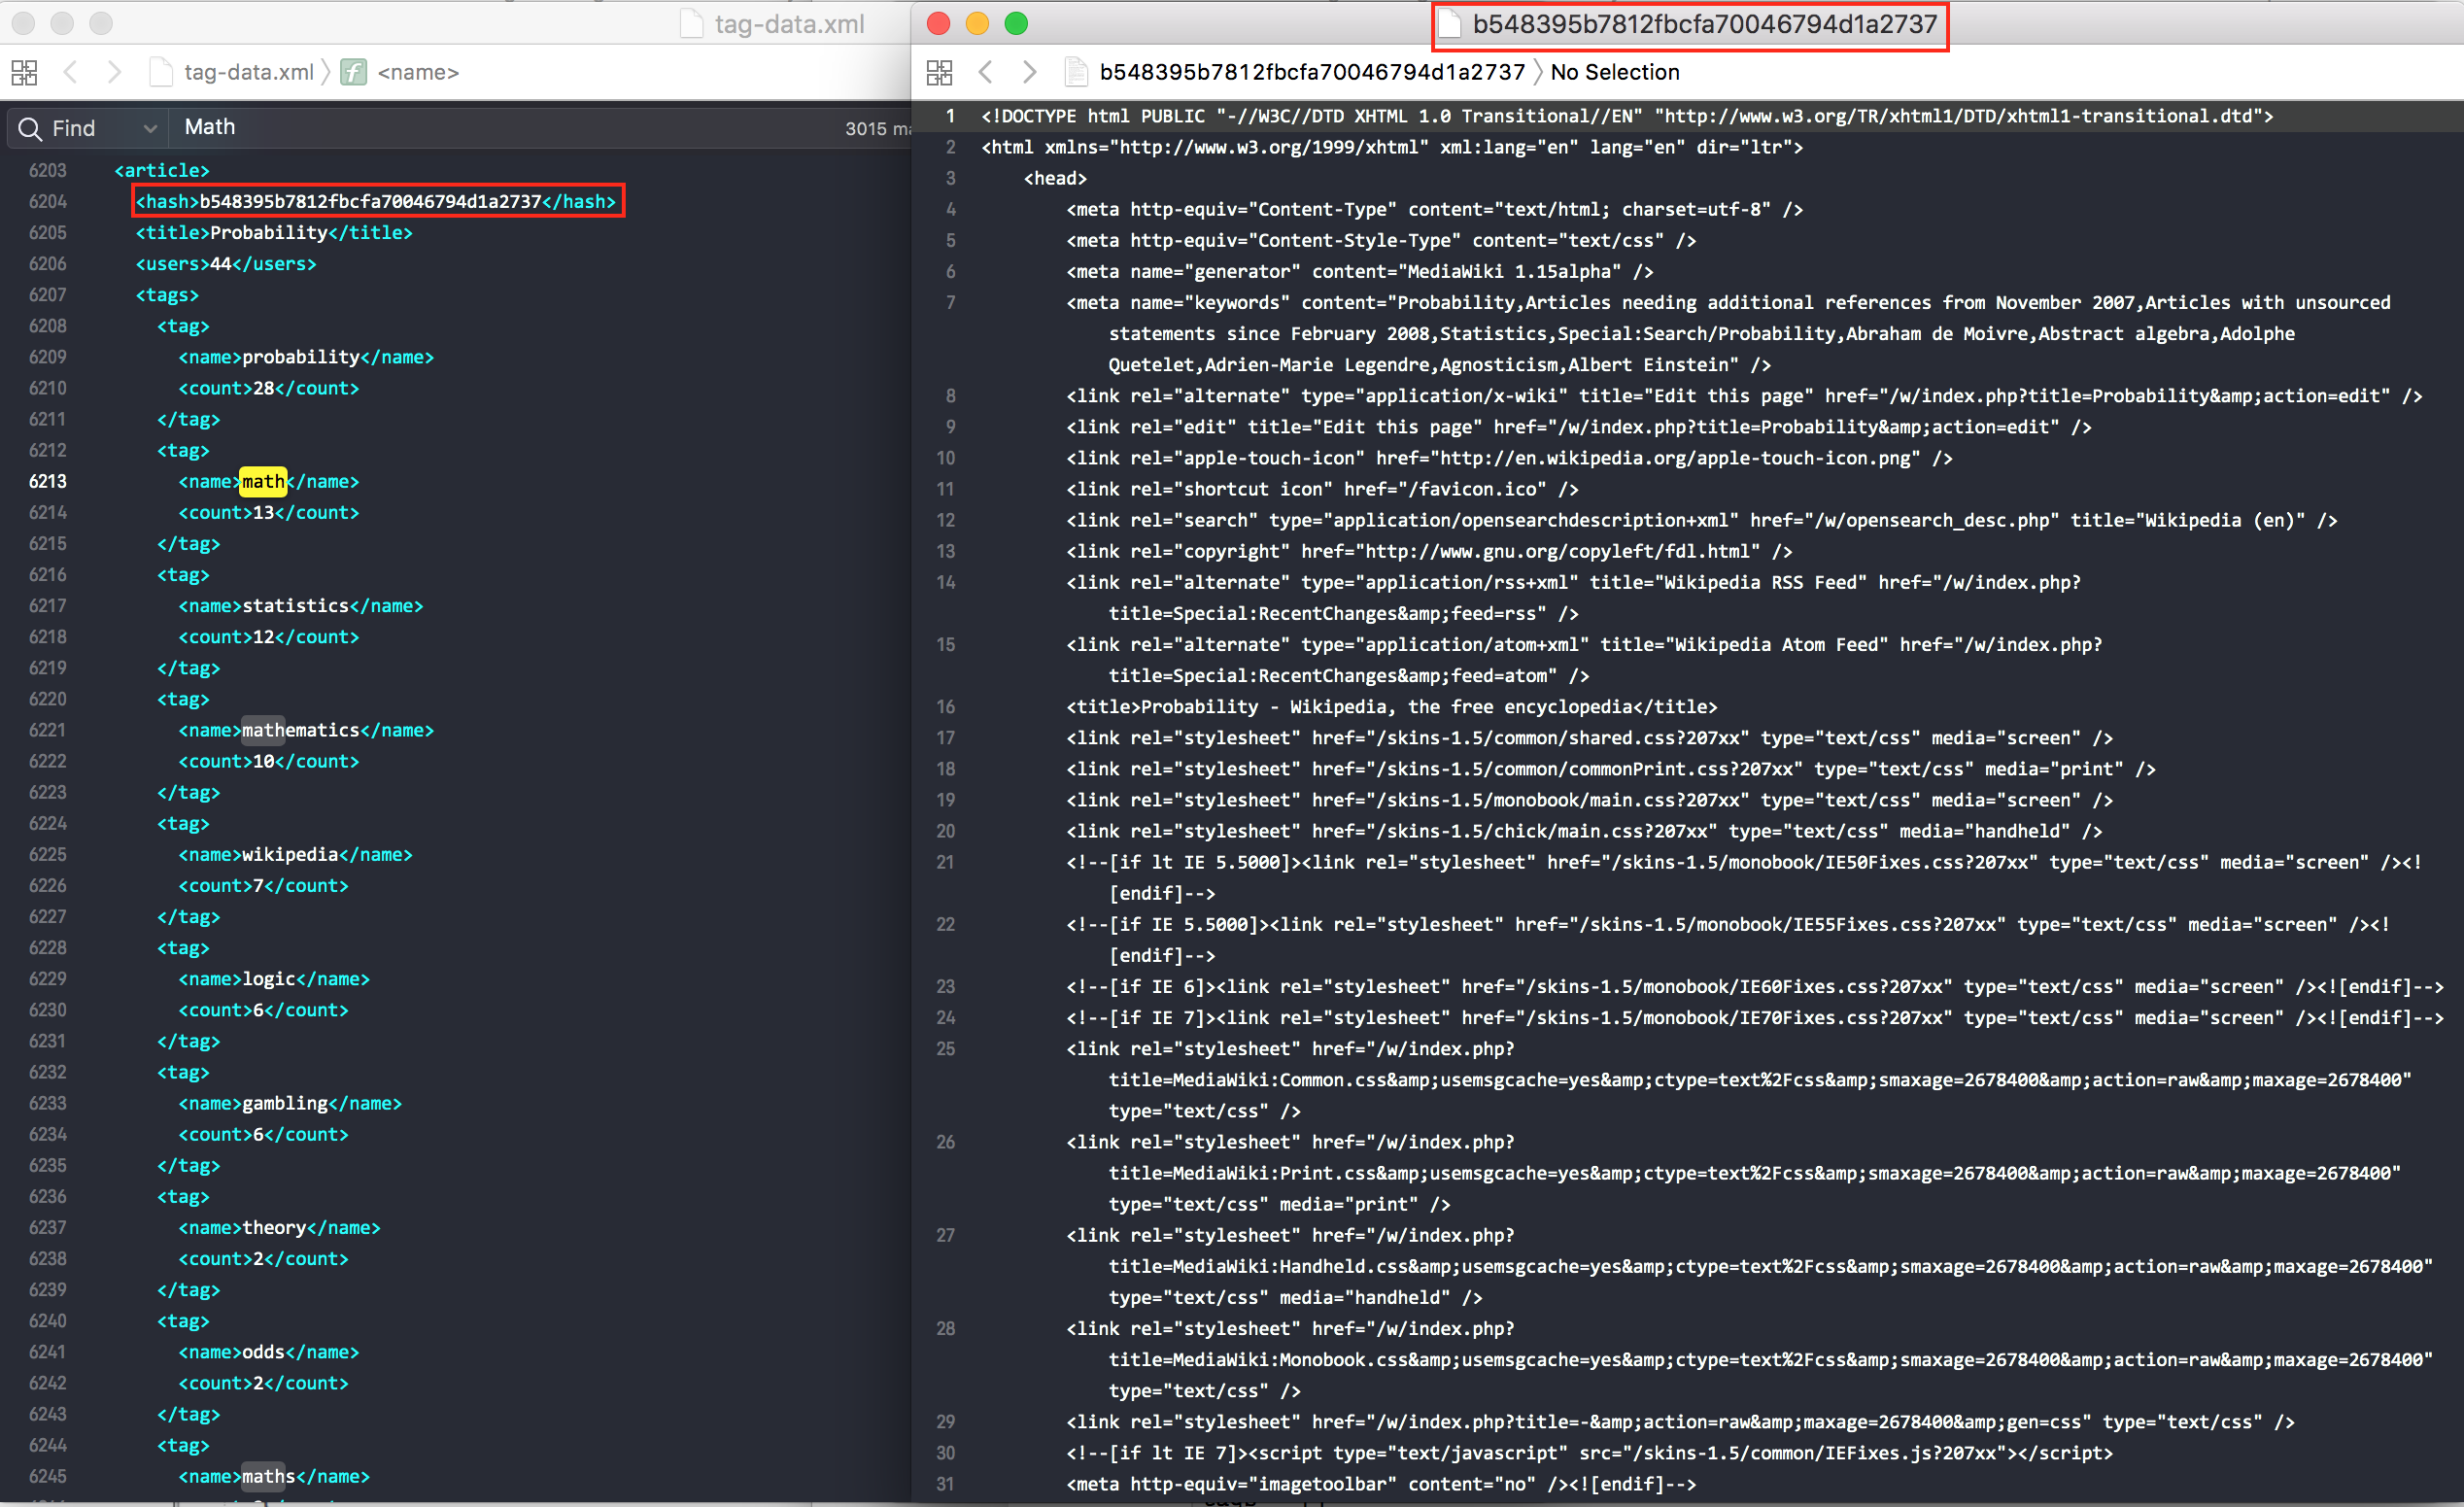

In [4]:
Image(filename = PATH_TO_DATASET + 'dataset_look.png')

## 1.1 Process tag-data.xml file

In [5]:
def getvalueofnode(node):
    """ return node text or None """
    return node.text if node is not None else None

In [6]:
"Read xml file and parse to dataframe"

parsed_xml = et.parse(PATH_TO_DATASET + "tag-data.xml")

hashes = []
titles = []
tags = []
for node in parsed_xml.getroot():           #for each article
    ha = getvalueofnode(node.find('hash'))  #take the unique hash
    ti = getvalueofnode(node.find('title')) #take the title
    if node.find('tags'):                   #take all tags that this article belongs to 
        temp = []
        for tag in node.find('tags').getchildren():
            temp.append(getvalueofnode(tag.find('name')))
    hashes.append(ha)
    titles.append(ti)
    tags.append(temp)
        
data = pd.DataFrame({
            'hash': hashes,
            'title': titles,
            'tags': tags
})

data.head()

,hash,tags,title
0,f9c3db3ffe088a3f42bdb544e5fc60a1,"[font, history, fonts, typography, designer, d...",Hermann Zapf
1,5619983c9b25f98d04bbe93cf7525b16,"[music, wikipedia, humor, reference, usa, soun...",Yakety Sax
2,2e171c3bf24e046ab812255a904c9b3d,"[tools, hardware, reference, wikipedia, wiki, ...",Torx
3,472ff0ae272e27710e978f773732787f,"[books, writer, people, wikipedia, writing, th...",Tom Robbins
4,f1993e5f9cf2526c7acb8caded787929,"[amazon, webservices, aws, cloud, web, ecommer...",Amazon Web Services


Each `hash` represents an article, follow by some tags and its title

In [7]:
data.tail()

,hash,tags,title
20759,dd4982dd78a1f598e47cfb96a22d8a6e,"[palestine, israel, middleeast, politics, hist...",Palestine
20760,2bf83ccb847f12da014a101f1e96a20b,"[color, srgb, colour, reference, wikipedia, we...",sRGB
20761,63377fae63a95eafc2751b7ee63ad792,"[politics, reference, legislative, people, gov...",United States Senate
20762,65094b6cb7cf713b0a4db5014e2f192e,"[art, davinci, wikipedia, vitruvian, drawing, ...",Vitruvian Man
20763,3ac5d7a36f10add5a88968dc50858012,"[canon, eos, photo, photography, xti, 400d, ca...",Canon EOS 400D


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20764 entries, 0 to 20763
Data columns (total 3 columns):
hash     20764 non-null object
tags     20764 non-null object
title    20762 non-null object
dtypes: object(3)
memory usage: 486.7+ KB


Since an article can have multiple tags. Let's figure out by counting all tags over the dataset.

In [9]:
def plot_term_frequency(df, col, n_terms):
    set_size()
    terms = []
    for texts in df[col]:
        for text in texts:
            terms.append(text)

    plt1 = pd.Series(terms).value_counts().sort_values(ascending=False)[:n_terms].to_frame()
    sns.barplot(plt1[0],plt1.index,palette=sns.color_palette('inferno_r',n_terms))
    plt.title('Top tags frequency')
    fig=plt.gcf()
    fig.set_size_inches(20,15)
    plt.show()

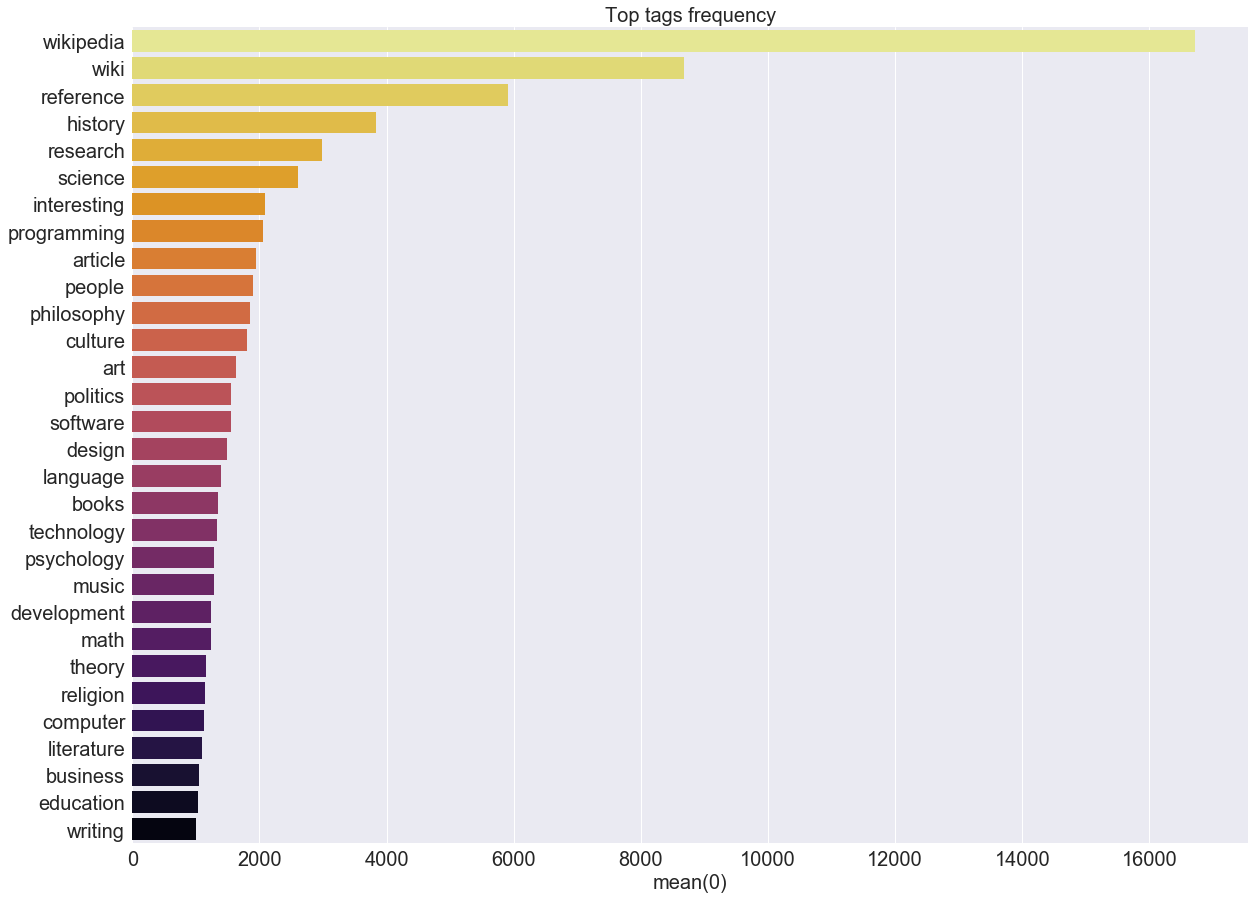

In [10]:
plot_term_frequency(data, 'tags', n_terms=30)

OK! We can see a lot of interesting categories. But we won't deal with all of this. The idea is first define a `CATEGORIES = ['music', 'politics',  'psychology', 'art', 'math', 'software']` and then try to filter the dataset. For instance, if an article A contains **either** more than one tag in `CATEGORIES` **or** nothing at all then A will be dropped, otherwise (A contains exactly one tab in `CATEGORIES`) A will be assigned by the common tag with `CATEGORIES`. 

In [11]:
CATEGORIES = ['music', 'politics',  'psychology', 'art', 'math', 'software']

In [159]:
def common_elem(list1, list2):
    """
        - Input : set1 and set2 st both has only one common element
        - Output: common element
    """
    return list(set(list1) - (set(list1) - set(list2)))[0]

In [160]:
def find_unique_tag(tags):
    if tags is not None:
        if len(set(CATEGORIES).intersection(tags)) == 1:
            return common_elem(CATEGORIES, tags)
        else:
            return 'NOT_UNIQUE'
    else :
        return 'NOT_UNIQUE'

In [14]:
data['label'] = data['tags'].apply(find_unique_tag, 1)
data.head()

,hash,tags,title,label
0,f9c3db3ffe088a3f42bdb544e5fc60a1,"[font, history, fonts, typography, designer, d...",Hermann Zapf,NOT_UNIQUE
1,5619983c9b25f98d04bbe93cf7525b16,"[music, wikipedia, humor, reference, usa, soun...",Yakety Sax,music
2,2e171c3bf24e046ab812255a904c9b3d,"[tools, hardware, reference, wikipedia, wiki, ...",Torx,NOT_UNIQUE
3,472ff0ae272e27710e978f773732787f,"[books, writer, people, wikipedia, writing, th...",Tom Robbins,NOT_UNIQUE
4,f1993e5f9cf2526c7acb8caded787929,"[amazon, webservices, aws, cloud, web, ecommer...",Amazon Web Services,NOT_UNIQUE


In [15]:
"drop an error in tag-data.xml line 1648437 hash = 'css'"
data = data[data['hash'] != 'css']
"drop an error in tag-data.xml line 1682323 hash = 'files'"
data = data[data['hash'] != 'files']

data = data[data['label'] != 'NOT_UNIQUE']
data['y'] = data['label'].apply(lambda x : CATEGORIES.index(x))
data = data.reset_index().drop(labels=['index','tags'], axis=1)

data.head()

,hash,title,label,y
0,5619983c9b25f98d04bbe93cf7525b16,Yakety Sax,music,0
1,5253e4edd95a559c3fd2488728a79393,ENFP,psychology,2
2,274256a924fb19d499c1cca3d9a1c20d,Lipogram,art,3
3,8dad3fb685fae7d54860350fe70523b0,Xinerama,software,5
4,85e480f085edc5116ef2f971b0332314,Srinivasa Ramanujan,math,4


In [17]:
print('------------Dataset after filter------------')

for cat in CATEGORIES:
    cat_df = data[data['label']==cat]
    print('Category *{c}* has {n} articles'.format(c=cat, n=len(cat_df)))

Category *music* has 957 articles
Category *politics* has 1325 articles
Category *psychology* has 1046 articles
Category *art* has 1175 articles
Category *math* has 1007 articles
Category *software* has 1353 articles


In [162]:
data.describe()

,y,length
count,6534.000000,6534.000000
mean,2.539639,1189.005816
std,1.696794,1157.082957
min,0.000000,100.000000
25%,1.000000,397.000000
50%,3.000000,791.000000
75%,4.000000,1572.000000
max,5.000000,12113.000000


In [19]:
len(data['hash'].unique()) == len(data)

True

In [20]:
len(data['label'].unique()) == len(CATEGORIES)

True

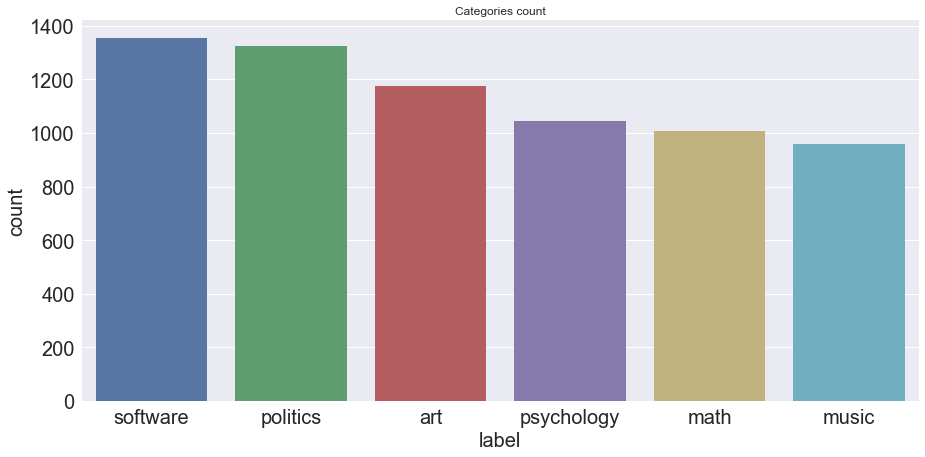

In [21]:
set_size()
plt.subplots(figsize=(15,7))
sns.set(style="darkgrid")
sns.countplot(x=data['label'],order=data['label'].value_counts().index)
plt.title('Categories count')
plt.show()

## 1.2 Process html files

Now, for each article we read and parse the content to dataframe. One way to take text of a html file is take all `<p>` element. To do it, we have a wonderful library called Beautiful Soup

In [22]:
def parse_content(hash_):
    f = codecs.open(PATH_TO_DATASET + "documents/" + hash_, 'r').read()
    soup = BeautifulSoup(f, 'lxml')
    content = [p.text for p in soup.find_all('p')]
    
    return content

In [23]:
data['raw_text'] = data['hash'].apply(parse_content)
data.head()

,hash,title,label,y,raw_text
0,5619983c9b25f98d04bbe93cf7525b16,Yakety Sax,music,0,"[""Yakety Sax"" is a 1963 45 rpm single written ..."
1,5253e4edd95a559c3fd2488728a79393,ENFP,psychology,2,"[ENFP (Extraversion, iNtuition, Feeling, Perce..."
2,274256a924fb19d499c1cca3d9a1c20d,Lipogram,art,3,"[A lipogram (from Greek lipagrammatos, ""missin..."
3,8dad3fb685fae7d54860350fe70523b0,Xinerama,software,5,[Xinerama is an extension to the X Window Syst...
4,85e480f085edc5116ef2f971b0332314,Srinivasa Ramanujan,math,4,[Mock theta functions\nRamanujan prime\nRamanu...


In [24]:
"The first three sentences of article positioned 20"

data.iloc[20]['raw_text'][:3]

['Probability, or chance, is a way of expressing knowledge or belief that an event will occur or has occurred. In mathematics the concept has been given an exact meaning in probability theory, that is used extensively in such areas of study as mathematics, statistics, finance, gambling, science, and philosophy to draw conclusions about the likelihood of potential events and the underlying mechanics of complex systems.',
 '']

## 1.3 Processed text

In [25]:
data = data.drop(labels=['hash','title'], axis=1)
data.head()

,label,y,raw_text
0,music,0,"[""Yakety Sax"" is a 1963 45 rpm single written ..."
1,psychology,2,"[ENFP (Extraversion, iNtuition, Feeling, Perce..."
2,art,3,"[A lipogram (from Greek lipagrammatos, ""missin..."
3,software,5,[Xinerama is an extension to the X Window Syst...
4,math,4,[Mock theta functions\nRamanujan prime\nRamanu...


Standardize raw text is the first thing we have to do. Depend on each dataset, we decide what to be removed. Need to take a look to some samples in the dataset and try to detect some special pattern that you want to exclude. And then repeat for many time until it is clean. For instant, I will remove `#`, `@`, `numbers`, and `punctuations`.

In [26]:
def standardize_text(df, text_field):
    
    """ 
        Input:
            - df: data's dataframe
            - text_field: column that we want to standardize
        Output:
            - dataframe contains `standardized` column
    """
    
    ht_re = r'#\S+'      #hashtags
    at_re = r'@\S+'      #@
    nb_re = " \d+"       #numbers
    
    
    punctuations = ["/","(",")","\\","|", "$", "£", ":",",",";","?", "!", "[", "]", "{","}"]
    
    new_text = []
    for texts in df[text_field]:
        
        # change ['hello John.', 'What are you doing?.', '', 'Do you want a coffee?.']
        # to     'hello John. What are you doing?. Do you want a coffee?.'
        texts = ' '.join(texts)
        temp = ''
        for text in texts.split('.'):

            text = text.replace("\\n"," ").replace("\n", " ") \
                       .replace("\'", " ").replace("-"," ")   \
                       .replace("_"," ").replace('\xa0'," ")  \
                       .replace('"', " ")

            for x in punctuations:
                text = text.replace(x , " ")

            text = re.sub(ht_re   , " ", text)
            text = re.sub(at_re   , " ", text)
            text = re.sub(nb_re   , " ", text)
            
            
            text = text.lower()

            temp += text + '.'

        new_text.append(temp)
    
    df['standardized_text'] = new_text
    return df

In [27]:
data = standardize_text(data, 'raw_text')
data.head()

,label,y,raw_text,standardized_text
0,music,0,"[""Yakety Sax"" is a 1963 45 rpm single written ...",yakety sax is a rpm single written by boot...
1,psychology,2,"[ENFP (Extraversion, iNtuition, Feeling, Perce...",enfp extraversion intuition feeling percep...
2,art,3,"[A lipogram (from Greek lipagrammatos, ""missin...",a lipogram from greek lipagrammatos missing...
3,software,5,[Xinerama is an extension to the X Window Syst...,xinerama is an extension to the x window syste...
4,math,4,[Mock theta functions\nRamanujan prime\nRamanu...,mock theta functions ramanujan prime ramanujan...


Secondly, since we want to have good indexing terms. A few steps needed have to be done:
    * Tokenization: splitting the text into words.
    * Lemmatization: process of reducing words. It helps reduces index size / increases information value of each indexing term.
    * Stopwords removing: term explicitely to be excluded from indexing.


In [28]:
def get_wordnet_pos(treebank_tag):
    """Map ['NN', 'NNS', 'NNP', 'NNPS'] to NOUN....."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def processing(sentence, tokenizer, stop, lemmatiser):
    "Input is a sentence"
    
    "Tokenization"
    sentence = tokenizer.tokenize(sentence)
    
    "Lemmatization"
    tokens_pos = pos_tag(sentence)
    tokens_pos = [(w,get_wordnet_pos(p)) for (w,p) in tokens_pos]
    sentence = [lemmatiser.lemmatize(w, pos=p) for (w,p) in tokens_pos if p != None]
    
    "Stopwords removing"
    sentence = [x for x in sentence if x not in stop ]
    
    return ' '.join(sentence)

def processing_text(df, text_field):
    lemmatiser = WordNetLemmatizer()
    stop = stopwords.words('english')
    tokenizer = RegexpTokenizer(r'\w+')
    processed_text = []
    for text in df[text_field]:
        temp = ''
        # Processed one sentence at a time
        for te in text.split('.'):
            temp += processing(te, tokenizer, stop, lemmatiser) + ' '
        processed_text.append(temp)
    df['processed_text'] = processed_text
    return df

In [29]:
start_time = time.time()
data = processing_text(data, 'standardized_text')
print("Processed all articles take %s seconds" % (time.time() - start_time))

data.head()

Processed all articles take 809.5841910839081 seconds


,label,y,raw_text,standardized_text,processed_text
0,music,0,"[""Yakety Sax"" is a 1963 45 rpm single written ...",yakety sax is a rpm single written by boot...,yakety sax rpm single write boot randolph jame...
1,psychology,2,"[ENFP (Extraversion, iNtuition, Feeling, Perce...",enfp extraversion intuition feeling percep...,enfp extraversion intuition feel perception ab...
2,art,3,"[A lipogram (from Greek lipagrammatos, ""missin...",a lipogram from greek lipagrammatos missing...,lipogram greek lipagrammatos miss letter kind ...
3,software,5,[Xinerama is an extension to the X Window Syst...,xinerama is an extension to the x window syste...,xinerama extension x window system enable mult...
4,math,4,[Mock theta functions\nRamanujan prime\nRamanu...,mock theta functions ramanujan prime ramanujan...,mock theta function ramanujan prime ramanujan ...


In [39]:
data.iloc[20]['raw_text'][:3]

['Probability, or chance, is a way of expressing knowledge or belief that an event will occur or has occurred. In mathematics the concept has been given an exact meaning in probability theory, that is used extensively in such areas of study as mathematics, statistics, finance, gambling, science, and philosophy to draw conclusions about the likelihood of potential events and the underlying mechanics of complex systems.',
 '',
 'The word probability does not have a consistent direct definition. In fact, there are two broad categories of probability interpretations, whose adherents possess different (and sometimes conflicting) views about the fundamental nature of probability:']

In [41]:
data.iloc[20]['standardized_text'][:500]

'probability  or chance  is a way of expressing knowledge or belief that an event will occur or has occurred. in mathematics the concept has been given an exact meaning in probability theory  that is used extensively in such areas of study as mathematics  statistics  finance  gambling  science  and philosophy to draw conclusions about the likelihood of potential events and the underlying mechanics of complex systems.  the word probability does not have a consistent direct definition. in fact  the'

In [42]:
data.iloc[20]['processed_text'][:500]

'probability chance way express knowledge belief event occur occur mathematics concept give exact meaning probability theory use extensively area study mathematics statistic finance gamble science philosophy draw conclusion likelihood potential event underlying mechanic complex system word probability consistent direct definition fact broad category probability interpretation adherent possess different sometimes conflicting view fundamental nature probability word probability derive probity measu'

In [33]:
data['length'] = data['processed_text'].apply(lambda x : len(x.split()))

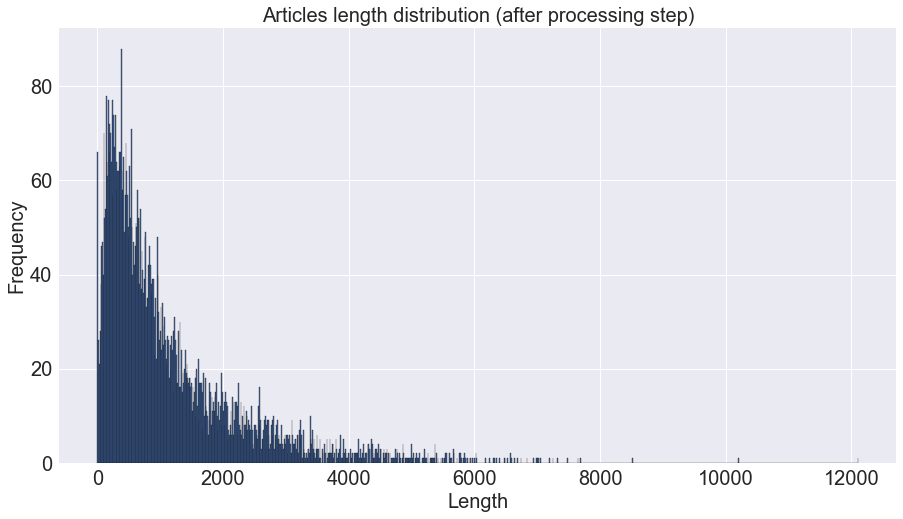

In [34]:
set_size()
plt.subplots(figsize=(15,8))
data['length'].hist(bins=1000,edgecolor='black')
plt.title('Articles length distribution (after processing step)')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

It's very difficult to deal with small articles. So I decided to drop articles where if its length is smaller than 100.

In [45]:
print('Number of articles: ',len(data))
print('Number of articles(length bigger than 100): ',len(data[data['length']>=100]))

Number of articles:  6863
Number of articles(length bigger than 100):  6534


In [46]:
data = data[data['length'] >= 100]
data = data.reset_index().drop(labels=['index','raw_text','standardized_text'], axis=1)
"Write to disk"
data.to_csv(PATH_TO_DATASET + 'processed_text.csv', index=False)
data.head()

,label,y,processed_text,length
0,music,0,yakety sax rpm single write boot randolph jame...,163
1,psychology,2,enfp extraversion intuition feel perception ab...,356
2,art,3,lipogram greek lipagrammatos miss letter kind ...,273
3,software,5,xinerama extension x window system enable mult...,303
4,math,4,mock theta function ramanujan prime ramanujan ...,2744


# 2) Features Generating

There are pleinty of ways to generate features. I choose 3 sample ways for testing:

* TF: Term Frequency (vocab_size = 4000)
* MAX TF: Top n-Term Most Frequency (min_df = 0.3)
* TFIDF: Term Frequency-Inverse Document Frequency (vocab_size = 4000)

In [130]:
"""
    TF Matrix with vocab_size = 4000
"""

vocab_size = 4000

tf_vectorizer = CountVectorizer(max_features=vocab_size)
tf = tf_vectorizer.fit_transform(data['processed_text'])
tf_feature_names = tf_vectorizer.get_feature_names()

"""
    TF Matrix with top max frequency
"""
max_tf_vectorizer = CountVectorizer(min_df=.03)
max_tf = max_tf_vectorizer.fit_transform(data['processed_text'])
max_tf_feature_names = max_tf_vectorizer.get_feature_names()

"""
    TFIDF Matrix with vocab_size40000 = 4000
"""

tfidf_vectorizer = TfidfVectorizer(max_features=vocab_size)
tfidf = tfidf_vectorizer.fit_transform(data['processed_text'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [145]:
VOCAB_SIZE = max_tf.shape[1] 
VOCAB_SIZE

3351

In [146]:
tf_matrix    = tf.toarray()*1.0 # parse to float is needed for using Variable (PyTorch)
max_tf_mtrix = max_tf.toarray()*1.0 
tfidf_matrix = tfidf.toarray()

data['TF']     = [x.reshape(1,vocab_size) for x in tf_matrix]
data['MAX_TF'] = [x.reshape(1,VOCAB_SIZE) for x in max_tf_mtrix]
data['TFIDF']  = [x.reshape(1,vocab_size) for x in tfidf_matrix]

In [147]:
data.head(5)

,label,y,processed_text,length,TF,MAX_TF,TFIDF
0,music,0,yakety sax rpm single write boot randolph jame...,163,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,psychology,2,enfp extraversion intuition feel perception ab...,356,"[[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.033526102836711216, 0.031138931702285..."
2,art,3,lipogram greek lipagrammatos miss letter kind ...,273,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,software,5,xinerama extension x window system enable mult...,303,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,math,4,mock theta function ramanujan prime ramanujan ...,2744,"[[0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.016570546212567806, 0.015390667662622..."


# 3) Autoencoder

In [126]:
class AutoEncoder(nn.Module):
    def __init__(self, original_dim, latent_dim):
        super(AutoEncoder, self).__init__()

        """  
             original_dim=>500=>250=>64=>latent_dim=>64=>250=>500=>1000=>original_dim
             ---------------ENCODER----------------
                                         --------------------DECODER------------------    
        """
        
        "Encoder"
        self.encoder = nn.Sequential(
            nn.Linear(original_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        
        "Decoder"
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, original_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [57]:
def flatten(list_):
    return [s for sublist in list_ for s in sublist]

In [58]:
def get_batch(X, batch_size, shuffle=True):
    """
        Partition X into n-chunks of size batch_size with shuffle
    """
    
    data_size = len(X)
    
    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_x = X[shuffle_indices]
    else:
        shuffled_x = X

    num_batches = int(data_size / batch_size) + 1
    
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1)*batch_size, data_size)
        if start_index != end_index:
            tX = shuffled_x[start_index:end_index]
            tX = flatten(tX)
            yield torch.Tensor(tX)

In [117]:
def train(X, nb_epochs, lr, batch_size, original_dim, latent_dim):
    """
        Training an autoencoder with data X
        This method will return an autoencoder
    """
    
    autoencoder = AutoEncoder(original_dim, latent_dim)
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(nb_epochs):
        sum_loss = 0
        for step, x in enumerate(get_batch(X, batch_size)):
            vab_x = Variable(x)                   
            encoded, decoded = autoencoder(vab_x)
            "Compute loss"
            loss = criterion(decoded, vab_x)
            "Reset gradients"
            optimizer.zero_grad()
            "Backprop, compute gradients"
            loss.backward()                       
            "Update gradients"
            optimizer.step()                      
            sum_loss += loss.data[0]
        
        print('Epoch: ', epoch, '| total loss: %.4f' % sum_loss)
    
    return autoencoder

# 4) Classify text using Autoencoder

In [62]:
def classification(X, y):
    """
        This method split dataset and then train with Logistic regression (multi-classes)
        Testing and return the metris: Accuracy, Precision and Recall
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X.data.numpy(), \
                                                        y, test_size=0.15, random_state=40)
    "Logistic regression multi-labels"
    logistic = LogisticRegression(multi_class="multinomial",solver='lbfgs', random_state=40)
    logistic.fit(X_train, y_train)
    y_predicted = logistic.predict(X_test)
    
    "Get metrics"
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')
    accuracy = accuracy_score(y_test, y_predicted)
    
    print("Accuracy = %.3f, Precision = %.3f, Recall = %.3f" % \
              (accuracy, precision, recall))
    
    return np.array(y_predicted), np.array(y_test)

To perform the classifition, I first using X to train a autoencoder and then using the encoder part to compress X from a high dimension space into latent spaces.

In [148]:
"Create an autoencoder with D = 30 latent variables"

autoencoder_classification = train(X=data['MAX_TF'], nb_epochs=20, lr=1e-3, batch_size=100, \
                                   original_dim=VOCAB_SIZE, latent_dim=30)

Epoch:  0 | total train loss: 168.2641
Epoch:  1 | total train loss: 163.6288
Epoch:  2 | total train loss: 161.8896
Epoch:  3 | total train loss: 160.5723
Epoch:  4 | total train loss: 160.4903
Epoch:  5 | total train loss: 162.2507
Epoch:  6 | total train loss: 158.9716
Epoch:  7 | total train loss: 159.3644
Epoch:  8 | total train loss: 159.1050
Epoch:  9 | total train loss: 158.7709
Epoch:  10 | total train loss: 159.1620
Epoch:  11 | total train loss: 159.1841
Epoch:  12 | total train loss: 158.4634
Epoch:  13 | total train loss: 158.5586
Epoch:  14 | total train loss: 160.1994
Epoch:  15 | total train loss: 158.6638
Epoch:  16 | total train loss: 158.1939
Epoch:  17 | total train loss: 157.9406
Epoch:  18 | total train loss: 158.2048
Epoch:  19 | total train loss: 158.1265


In [149]:
X, y = data['MAX_TF'], data['y']

"Use the encode part of autoencoder for compressing X"
encoded_X, decoded_X = autoencoder_classification(Variable(torch.Tensor(flatten(X))))

"Perform classifition"
y_predicted, y_test = classification(encoded_X, y)

Accuracy = 0.861, Precision = 0.866, Recall = 0.861


In [150]:
"Accuracy across classes"

for i in range(len(CATEGORIES)):
    class_pred = y_predicted[np.where(y_test == i)]
    class_true = y_test[np.where(y_test == i)]
    precision = precision_score(class_true, class_pred, pos_label=None, average='weighted')
    recall = recall_score(class_true, class_pred, pos_label=None, average='weighted')
    accuracy = accuracy_score(class_true, class_pred)
    print("Class %d: Accuracy = %.3f" % (i, accuracy))

Class 0: Accuracy = 0.866
Class 1: Accuracy = 0.861
Class 2: Accuracy = 0.857
Class 3: Accuracy = 0.829
Class 4: Accuracy = 0.833
Class 5: Accuracy = 0.915


# 5) PCA vs Latent dimension of Autoencoder

In [77]:
def plot_PCA(X, y, pca):
        set_size()
        plt.figure(figsize=(20, 20)) 
        
        colors = ['blue', 'red', 'cyan', 'purple', 'green','black']
        
        if pca:
            plt.title('PCA')
            X = [x.tolist()[0] for x in X]
            pca = PCA(n_components=2)
            pca_scores = pca.fit_transform(np.array(X))
            plt.scatter(pca_scores[:,0], pca_scores[:,1], s=11, alpha=1, c=y, cmap=matplotlib.colors.ListedColormap(colors))
        else:
            plt.title('Latent dimension from Autoencoder')
            plt.scatter(list(X[:,0]), list(X[:,1]), s=11, alpha=.8, c=y, cmap=matplotlib.colors.ListedColormap(colors))
        
        handles = []
        for idx, c in enumerate(CATEGORIES):
            handles.append(mpatches.Patch(color=colors[idx], label=c))
        
        plt.legend(handles=handles, prop={'size': 20})
        plt.show()

In order to see whether our features are capturing information that is relevant to our problem(classification), it is a good idea to visualize them and see if the classes look well separated. Visualizing data in high dimensions is impossible, techniques like PCA will help us project the data down to two dimensions. 

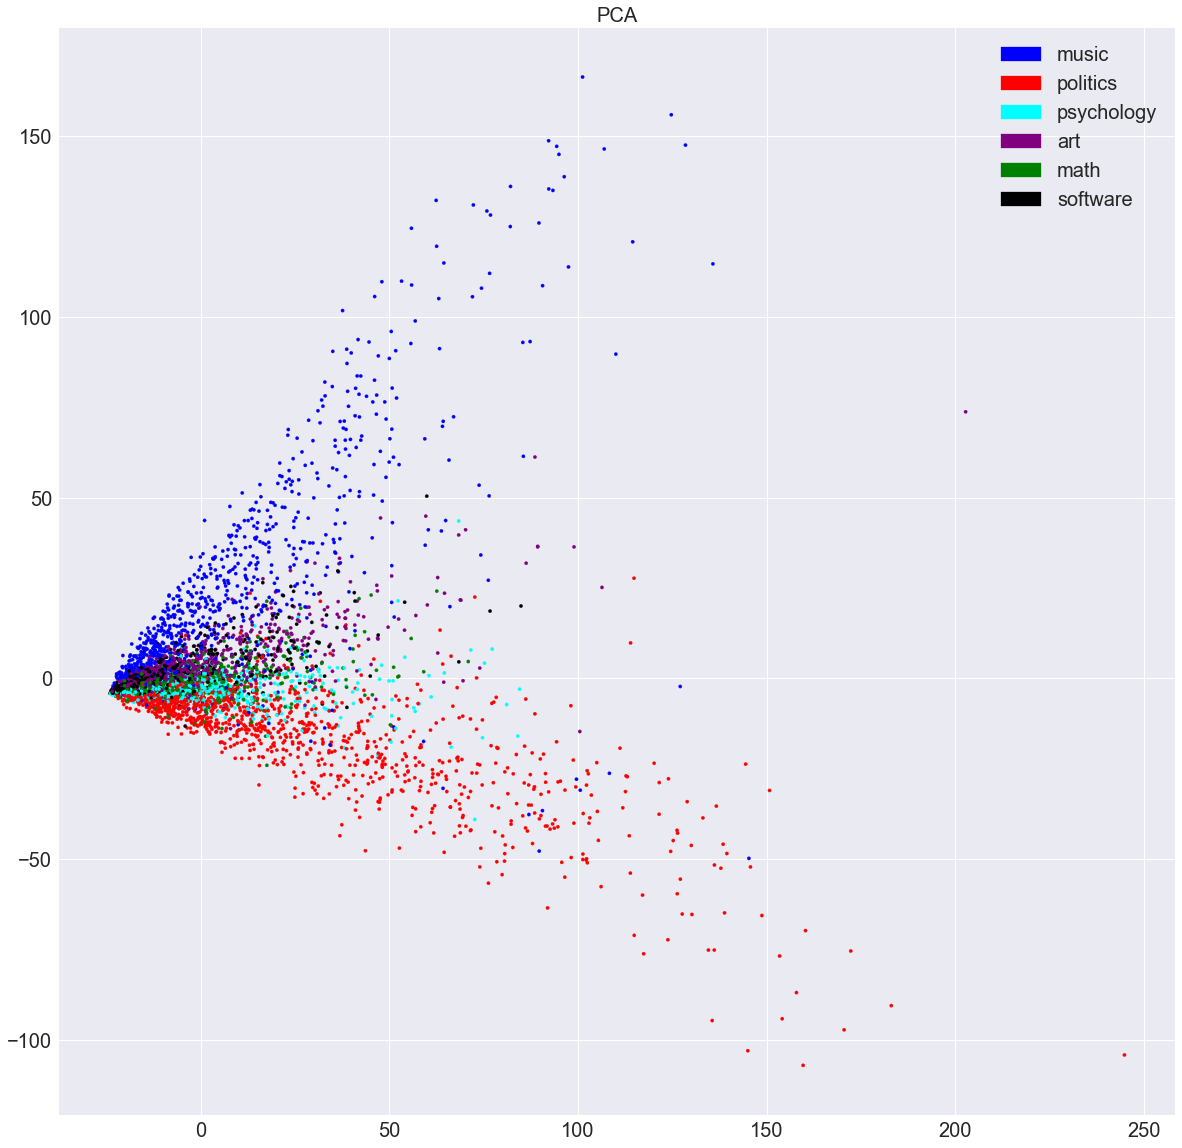

In [78]:
plot_PCA(data['TF'], data['y'], pca=True)

Another way to visualize is using an autoencoder. The same technique when we perform the classification, the only different is now we will create an autoencoder with D = 2 latent variables (since want to visualize data down to two dimensions).

In [152]:
autoencoder_plot = train(X=data['MAX_TF'], nb_epochs=20, lr=.005, \
                batch_size=100, original_dim=VOCAB_SIZE, latent_dim=2)

Epoch:  0 | total train loss: 163.8243
Epoch:  1 | total train loss: 162.5193
Epoch:  2 | total train loss: 161.7359
Epoch:  3 | total train loss: 160.6917
Epoch:  4 | total train loss: 161.2827
Epoch:  5 | total train loss: 162.2804
Epoch:  6 | total train loss: 161.0466
Epoch:  7 | total train loss: 160.7865
Epoch:  8 | total train loss: 160.4528
Epoch:  9 | total train loss: 161.4192


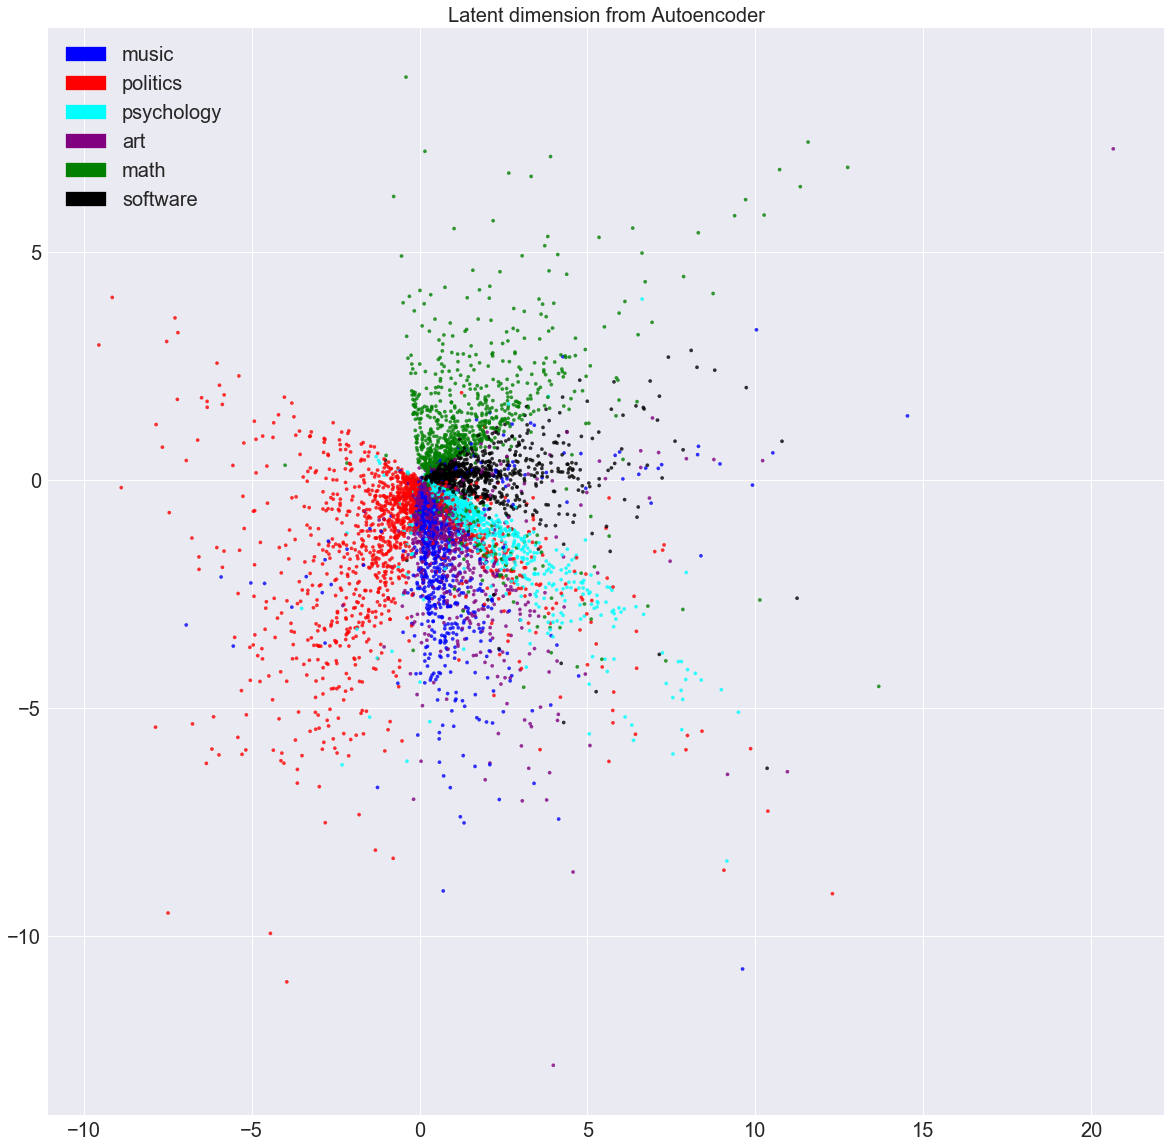

In [153]:
tensor_data = torch.Tensor(flatten(data['MAX_TF']))
encoded_data, decoded_data = autoencoder_plot(Variable(tensor_data))

plot_PCA(encoded_data.data, data['y'], pca=False)

# 6) Discussion